# ICARA 2025 Experiment

This notebook is an implementation of the experiment showcased in the paper **["A digital twin for optical tracking systems design"]()** submitted for [ICARA 2025](https://www.icara.us), which is a virtual re-creation of the experiment showcased in the paper **["Optical tracking system based on COTS components"](https://ieeexplore.ieee.org/document/10053039)** submitted for [IPAS 2022](https://ipas.ieee.tn)

---

In [1]:
# Importing modules...
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sys
sys.path.append('../..') # Go back to base directory

from modules.plot.viewer3d import Viewer3D

from modules.vision.synchronizer import Synchronizer
from modules.vision.linear_projection import extract_fov

from modules.integration.client import Client
from modules.integration.coppeliasim.server import CoppeliaSim_Server
from modules.integration.coppeliasim.camera import CoppeliaSim_Camera

from modules.integration.mocaprasp.calib_data import *

from coppeliasim_zmqremoteapi_client import RemoteAPIClient
client = RemoteAPIClient()    # Client object 
sim = client.getObject('sim') # Simulation object

# Setting the Scene

All `Camera` and `Client` objects will be instanciated right along with the `Server` object. A CoppeliaSim scene will be requested given the arbitrary camera parameters.

---

In [2]:
n_clients = 4 # Number of clients in the arena
clients = [Client(camera=CoppeliaSim_Camera()) for c in range(n_clients)]  # Clients list

# Create server
server = CoppeliaSim_Server(clients=clients,
                            server_address=('127.0.0.1', 8888),
                            controller_address=('127.0.0.1', 7777))

# Standard Capture

With all calibration done, a standard capture routine can be requested for the arena's usual operation.

---

In [3]:
n_clients = 4 # Number of clients in the arena
clients = []  # Clients list

# Create clients
for (K, k_d, R_t) in zip(all_intrinsic_matrices, all_distortion_coefficients, all_poses):
    # Used sensor resolution for the real twin experiment
    resolution = (960, 720)

    # Extract FOV from intrinsic matrix and resolution
    fov_degrees = extract_fov(K, resolution)

    # Generate associated camera model
    camera = (CoppeliaSim_Camera(resolution=resolution, 
                                 fov_degrees=fov_degrees,     
                                 pose=R_t.copy(),
                                 distortion_model='fisheye',
                                 distortion_coefficients=k_d.copy(),
                                 snr_dB=27.5
                                 ))

    clients.append(Client(camera=camera))

server.update_clients(clients)

# Request scene with the associated server clients
if not server.request_scene():
    sys.exit() # Scene request failed!

# Capture specifications
blob_count = 1 # Number of expected markers
capture_time = 30.0 # In seconds
window = 3 # The minimum ammount of points for interpolating 
throughput = 40 # Triangulated scenes per second
step = 1 / throughput # Interpolation timestep

# Capture synchronizer
synchronizer = Synchronizer(blob_count, window, step, capture_time)

# Request capture (start simulation)
if not server.request_capture(synchronizer):
    sys.exit() # Capture request failed!

# Wait for client identification
server.register_clients()

[SERVER] Wrapping up CoppeliaSim scene info
[SERVER] Scene info sent
[SERVER] Scene set!
[SERVER] Capture info sent
[SERVER] Capture confirmed!
[SERVER] Waiting for clients...
	Client 0 registered
	Client 1 registered
	Client 2 registered
	Client 3 registered
[SERVER] All clients registered!


In [4]:
verbose = False

timeout = 5 # In seconds
server.udp_socket.settimeout(timeout) # Set server timeout
print(f'[SERVER] Timeout set to {timeout} seconds\n')

T = 0 # Triangulation index
T_ = 0 # Ideal triangulation index
max_T = int(capture_time * throughput - 1) # Max triangulation index
step_delay = 2 # Numbers of step allowed for the triangulation to delay 
visualizer_address = ('127.0.0.1', 6666)

all_triangulated_markers = np.full((int(capture_time * throughput), 3, 1), np.nan) # Marker capture profile
all_marker_positions = np.full((int(capture_time * throughput), 3, 1), np.nan) # Ground truth position of the marker positions

# Breaks in the timeout
while True:
    # Wait for message - Event guided!
    try:
        message_bytes, address = server.udp_socket.recvfrom(server.buffer_size)

    except TimeoutError:
        print('\n[SERVER] Timed Out!')
        break # Close capture loop due to timeout

    except ConnectionResetError:
        print('\n[SERVER] Connection Reset!')
        continue # Jump to wait for the next message
    
    # Check if message comes from any of the clients
    try:
        ID = server.client_addresses[address] # Client Identifier
    
    except:
        # Check if message comes from the Controller
        if address == server.controller_address:
            # Show sender
            if verbose: print(f'> Received message from Controller ({address[0]}, {address[1]}):')

            # Decode message
            try:
                message = np.frombuffer(message_bytes, dtype=np.float32)

            except:
                if verbose: print('> Couldn\'t decode message')

                continue # Jump to wait for the next message

            # Empty message
            if not message.size:
                if verbose: print('\tEmpty message')

                continue # Jump to wait for the next message

            # Extracting the message's PTS
            PTS = message[-1] # Last element of the message 
            marker_position = message[:-1].reshape(3, 1) # All but last element (reserved for PTS)

            # Get time index based on the simulation timestep
            t = np.rint(PTS / step).astype(int)

            try: 
                all_marker_positions[t] = marker_position

            except:
                pass # Don't access array if index is out of bounds 

        else:
            if verbose: print('> Address not recognized')

        continue # Jump to wait for the next message
    
    # Show sender
    if verbose: print(f'> Received message from Client {ID} ({address[0]}, {address[1]}):')

    # Decode message
    try:
        message = np.frombuffer(message_bytes, dtype=np.float32)

    except:
        if verbose: print('> Couldn\'t decode message')

        continue # Jump to wait for the next message

    # Empty message
    if not message.size:
        if verbose: print('\tEmpty message')

        continue # Jump to wait for the next message

    # Extracting the message's PTS
    PTS = message[-1] # Last element of the message 
    T_idx = np.rint(PTS / step).astype(int) # Triangulation index of the message

    # Update ideal triangulation index
    T_ = T_ if T_idx < T_ else max_T if T_idx > max_T else T_idx

    # Check for delay
    if T_ - T > step_delay:
        T = T_ # If delay is exceeded, update triangulation index to last message

    # Valid message is [u, v, A] per blob and the PTS of the message
    if message.size !=  3 * blob_count + 1:

        if message.size == 1: # Only PTS
            if verbose: print(f'\tNo blobs were detected - {PTS :.3f} s')

        else: 
            if verbose: 
                print(f'\tWrong blob count or corrupted message')
                print(f'\tCorrupted Message: {message}')

        continue # Jump to wait for the next message

    # Extracting blob data (coordinates & area)
    blob_data = message[:-1].reshape(-1, 3) # All but last element (reserved for PTS)

    # Extracting centroids
    blob_centroids = blob_data[:,:2] # Ignoring their area

    # Undistorting blobs centroids
    undistorted_blobs = server.clients[ID].camera.undistort_points(blob_centroids)          

    # Print blobs
    if verbose:
        print(f'\tDetected Blobs - {PTS :.3f} s')
        print('\t' + str(blob_data).replace('\n', '\n\t'))

    # Save data
    valid_data = server.clients[ID].synchronizer.add_data(undistorted_blobs, PTS)

    if verbose: 
        if valid_data:
            print('\tData Accepted!')
        else:
            print('\tData Refused!')

    synchronizers = [c.synchronizer for c in server.clients]
    
    available = [] # Available cameras for triangulation in a PTS
    for ID, S in enumerate(synchronizers):
        # Is there interpolated data? Non-interpolated blobs are negative!
        if np.any(S.sync_blobs[T] >= 0): 
            available.append(ID)

    if verbose:
        print(f'\tCameras available for {T}: {available}')
        
    # If no pair is available to triangulate
    if len(available) < 2:
        if verbose:
            print(f'\tNo pair available at {T}')
        continue # Jump to wait for the next message
    
    triangulated = False # Triangulation success flag
    reference = available[-1] # Received message client ID 
    for auxiliary in available[:-1]:
        blobs_pair = [synchronizers[reference].sync_blobs[T],
                      synchronizers[auxiliary].sync_blobs[T]]
        
        triangulated_markers = server.multiple_view.triangulate_by_pair((reference, auxiliary), blobs_pair)

        # Triangulation is not reliable
        if np.isnan(triangulated_markers).any():
            continue # Try triangulation with another pair
        
        try:
            all_triangulated_markers[T] = triangulated_markers
    
            triangulated = True # Toggle triangulation success flag

        except:
            pass # Don't access array if index is out of bounds 

        break # Triangulation succeeded, continue process
    
    if not triangulated:
        if len(available) < n_clients: # Wait for every client to triangulate
            continue # Jump to wait for the next message
        
        # No pair was able to triangulate, move on
        if verbose:
            print(f'\tCould not triangulate at {T}')

    else:
        if verbose:
            print(f'\tTriangulated at {T}/{T_}')

    # Update to next triangulation index
    T = max_T if T + 1 > max_T else T + 1 # Clip to valid indexes

# Join collected data
all_triangulated_markers = np.hstack(all_triangulated_markers)
all_marker_positions = np.hstack(all_marker_positions)

[SERVER] Timeout set to 5 seconds


[SERVER] Timed Out!


In [5]:
# Create the Scene Viewer
scene = Viewer3D(title='Capture Profile', 
                 size=10)

# Add camera frames to the scene
for ID, camera in enumerate(server.multiple_view.camera_models): 
    scene.add_frame(camera.pose, f'Camera {ID}', axis_size=0.4)

# Add new reference
scene.add_frame(np.eye(4), 'Reference', axis_size=0.4)

# Add triangulated markers to the scene
scene.add_points(all_triangulated_markers, f'Triangulated positions')

# Add ground turh position of the markers to the scene
scene.add_points(all_marker_positions, f'Ground truth positions')

# Plot scene
scene.figure.show(renderer='notebook_connected')

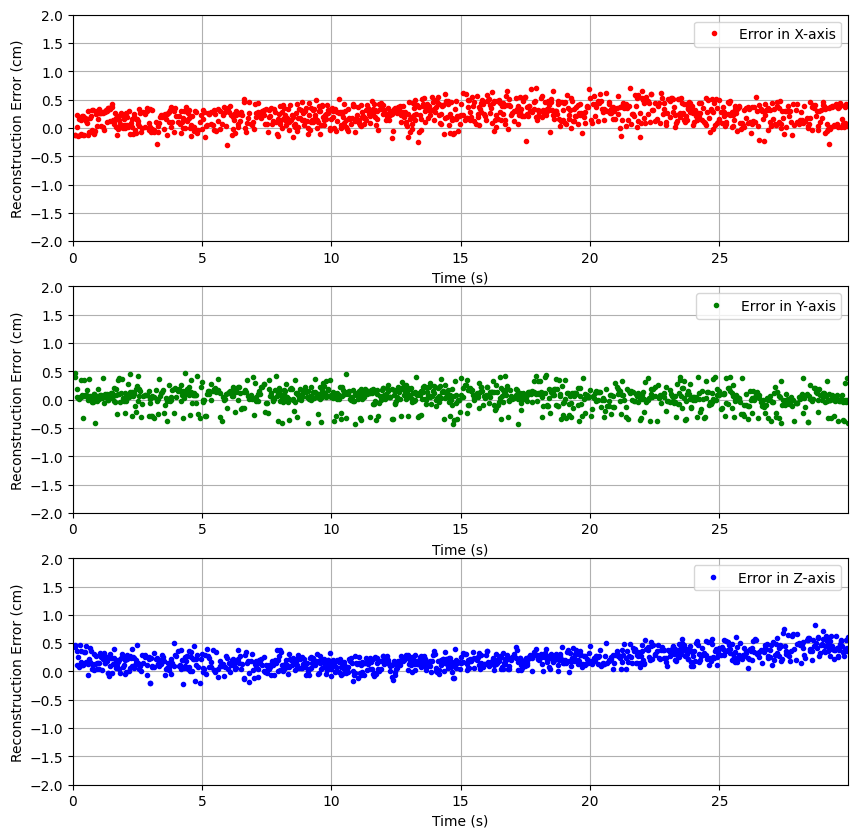

Average Error in X-axis: 0.229 cm
Average Error in Y-axis: 0.046 cm
Average Error in Z-axis: 0.217 cm
Average Reconstruction Error: 0.412 cm

Error Standard Deviation in X-axis: 0.180 cm
Error Standard Deviation in Y-axis: 0.174 cm
Error Standard Deviation in Z-axis: 0.156 cm
Error Standard Deviation: 0.136 cm


In [6]:
# Calculate error vector for each timestep
error_vectors = all_triangulated_markers - all_marker_positions
time_vector = np.arange(error_vectors.shape[1]) * step

# Filter values for analysis
filtered_error_vectors = error_vectors[:, ~np.isnan(error_vectors).any(axis=0)] # Remove nan value vectors

figure = plt.figure()
figure.set_figwidth(10)
figure.set_figheight(10)

plt.subplot(3, 1, 1)
plt.xlabel("Time (s)")
plt.ylabel("Reconstruction Error (cm)")
plt.grid()
plt.ylim(-2, 2)
plt.xlim(0, time_vector[-1])
plt.plot(time_vector, error_vectors[0] * 1e2, 'r.', label='Error in X-axis')
plt.legend()

plt.subplot(3, 1, 2)
plt.xlabel("Time (s)")
plt.ylabel("Reconstruction Error (cm)")
plt.grid()
plt.ylim(-2, 2)
plt.xlim(0, time_vector[-1])
plt.plot(time_vector, error_vectors[1] * 1e2, 'g.', label='Error in Y-axis')
plt.legend()

plt.subplot(3, 1, 3)
plt.xlabel("Time (s)")
plt.ylabel("Reconstruction Error (cm)")
plt.grid()
plt.ylim(-2, 2)
plt.xlim(0, time_vector[-1])
plt.plot(time_vector, error_vectors[2] * 1e2, 'b.', label='Error in Z-axis')
plt.legend()

plt.show()

print(f'Average Error in X-axis: {np.abs(np.mean(filtered_error_vectors[0])) * 1e2:.3f} cm')
print(f'Average Error in Y-axis: {np.abs(np.mean(filtered_error_vectors[1])) * 1e2:.3f} cm')
print(f'Average Error in Z-axis: {np.abs(np.mean(filtered_error_vectors[2])) * 1e2:.3f} cm')
print(f'Average Reconstruction Error: {np.mean(np.linalg.norm(filtered_error_vectors, axis=0)) * 1e2:.3f} cm')
print()
print(f'Error Standard Deviation in X-axis: {np.std(filtered_error_vectors[0]) * 1e2:.3f} cm')
print(f'Error Standard Deviation in Y-axis: {np.std(filtered_error_vectors[1]) * 1e2:.3f} cm')
print(f'Error Standard Deviation in Z-axis: {np.std(filtered_error_vectors[2]) * 1e2:.3f} cm')
print(f'Error Standard Deviation: {np.std(np.linalg.norm(filtered_error_vectors, axis=0)) * 1e2:.3f} cm')